Project Description

In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os

In [2]:
image_path1 = "./dataset/1/"
image_path2 = "./dataset/2/"
image_path3 = "./dataset/3/"
image_path4 = "./dataset/4/"

In [3]:
# Define the path to your JSON file
json_file_path1 = os.path.join(image_path1, 'annotation1.json')
json_file_path2 = os.path.join(image_path2, 'annotation2.json')
json_file_path3 = os.path.join(image_path3, 'annotation3.json')
json_file_path4 = os.path.join(image_path4, 'annotation4.json')

def read_json_file(file_path, encoding='utf-8'):
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return json.load(f)
        except UnicodeDecodeError as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"JSON file {file_path} not found.")
    return None

In [4]:
# reading from json files
data1 = read_json_file(json_file_path1)
data2 = read_json_file(json_file_path2)
data3 = read_json_file(json_file_path3)
data4 = read_json_file(json_file_path4)

In [5]:
data1_annotation = data1["_via_img_metadata"]
data4_annotation = data4["_via_img_metadata"]
list(data1_annotation.values())[0]

{'filename': '0_00_01_879__0_00_02_238_0000000001280072012800720.jpeg',
 'size': 226504,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 12,
    'y': 12,
    'width': 113,
    'height': 71},
   'region_attributes': {'language': 'eng', 'text': 'bella\nMEN'}}],
 'file_attributes': {}}

In [6]:
# data1_image_list = data1['_via_image_id_list']
# data2_image_list = data2['_via_image_id_list']
# data3_image_list = data3['_via_image_id_list']
# data4_image_list = data4['_via_image_id_list']

# print("total " + str(len(data1_image_list) + len(data2_image_list) + len(data3_image_list) + len(data4_image_list)) + " images")

In [7]:
class OCRDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_info = list(self.annotations.values())[idx]
        img_path = os.path.join(self.img_dir, img_info['filename'])
        image = Image.open(img_path).convert("RGB")
        
        regions = img_info['regions']
        bboxes = []
        labels = []
        
        for region in regions:
            shape_attributes = region['shape_attributes']
            region_attributes = region['region_attributes']
            
            if shape_attributes['name'] == 'rect':
                x = shape_attributes['x']
                y = shape_attributes['y']
                width = shape_attributes['width']
                height = shape_attributes['height']
                bboxes.append([x, y, x + width, y + height])
            elif shape_attributes['name'] == 'polyline':
                all_points_x = shape_attributes['all_points_x']
                all_points_y = shape_attributes['all_points_y']
                bboxes.append([min(all_points_x), min(all_points_y), max(all_points_x), max(all_points_y)])
            
            labels.append(region_attributes['text'])
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, bboxes, labels

In [8]:
# Define the custom collate function
def custom_collate_fn(batch):
    images = []
    bboxes = []
    labels = []

    for sample in batch:
        images.append(sample[0])
        bboxes.append(sample[1])
        labels.append(sample[2])

    images = torch.stack(images, dim=0)
    return images, bboxes, labels

In [9]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = OCRDataset(annotations=data4_annotation, img_dir='./dataset/4/', transform=transform)


In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

def visualize_image(image, bboxes, labels):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    myanmar_font = FontProperties(fname="./mmrtext.ttf")
    
    for bbox, label in zip(bboxes, labels):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, fontproperties=myanmar_font, color='white', backgroundcolor='red', fontsize=12)
    
    plt.show()


In [47]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)


In [48]:
# Profiling DataLoader
import time
start_time = time.time()
for i, (images, bboxes, labels) in enumerate(dataloader):
    if i == 0:
        print(f"Time to load first batch: {time.time() - start_time} seconds")
        break

Time to load first batch: 0.0750889778137207 seconds


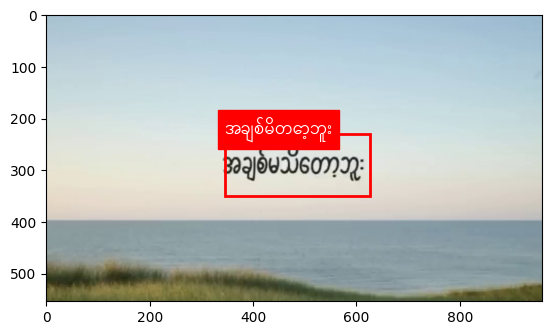

In [49]:
images, bboxes, labels = next(iter(dataloader))

# Visualize the first image in the batch
image = images[0]
bbox = bboxes[0]
label = labels[0]

visualize_image(image, bbox, label)

In [50]:
label

['အချစ်မိတော့ဘူး']